In [4]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import cv2
import numpy as np

In [4]:
transform = transforms.Compose([transforms.Resize(255),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor()])

dataset = datasets.ImageFolder('D:/amogh/python_projects/ML/Mask_detection/dataset', transform=transform)
                                

In [5]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [6]:
train_data = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True,num_workers=1,pin_memory=True)
test_data = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True,num_workers=1,pin_memory=True)

In [5]:
torch.cuda.is_available()

False

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [8]:
next(iter(train_data))[0].shape

torch.Size([32, 3, 224, 224])

In [17]:
# model=nn.Sequential(nn.Conv2d(3,16,3),nn.ReLU(),nn.MaxPool2d(2,2),nn.Conv2d(16,32,3),nn.ReLU(),nn.MaxPool2d(2,2),nn.Conv2d(32,16,3),nn.ReLU(),nn.MaxPool2d(2,2),nn.Flatten(),nn.Linear(16*26*26,256),nn.ReLU(),nn.BatchNorm1d(256),nn.Dropout(p=0.5),nn.Linear(256,2)).to(device)
model=nn.Sequential(nn.Conv2d(3,16,5),nn.ReLU(),nn.MaxPool2d(4,4),nn.Conv2d(16,8,5),nn.ReLU(),nn.MaxPool2d(4,4),nn.Flatten(),nn.Linear(8*12*12,256),nn.ReLU(),nn.BatchNorm1d(256),nn.Dropout(p=0.5),nn.Linear(256,2)).to(device)
criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(),lr=0.001,weight_decay=1e-2)

In [18]:
from torchsummary import summary
summary(model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 220, 220]           1,216
              ReLU-2         [-1, 16, 220, 220]               0
         MaxPool2d-3           [-1, 16, 55, 55]               0
            Conv2d-4            [-1, 8, 51, 51]           3,208
              ReLU-5            [-1, 8, 51, 51]               0
         MaxPool2d-6            [-1, 8, 12, 12]               0
           Flatten-7                 [-1, 1152]               0
            Linear-8                  [-1, 256]         295,168
              ReLU-9                  [-1, 256]               0
      BatchNorm1d-10                  [-1, 256]             512
          Dropout-11                  [-1, 256]               0
           Linear-12                    [-1, 2]             514
Total params: 300,618
Trainable params: 300,618
Non-trainable params: 0
-------------------------------

In [19]:
epochs=2
for epoch in range(epochs):
    cor=0
    for (imgs,labels) in train_data:
        imgs = imgs.to(device)
        labels=labels.to(device)
        output=model(imgs)
        loss=criterion(output,labels)
        for param in model.parameters():
            param.grad=None
        loss.backward()
        optimiser.step()

        
        _,predicted = torch.max(output.data,1)
        cor+=(predicted == labels).sum().item()
        # acc=sum(output.round()==y_train)/len(y_train)
    print(epoch,cor)

0 2883
1 2967


In [20]:
torch.cuda.memory_allocated(0)
import matplotlib.pyplot as plt

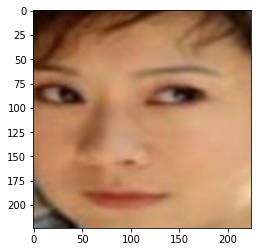

1 1


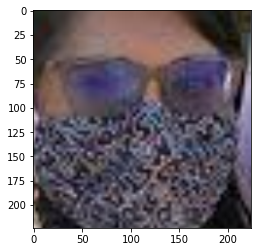

0 0


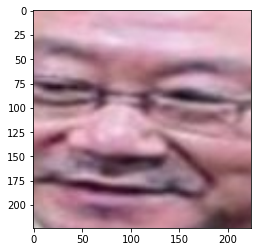

1 1


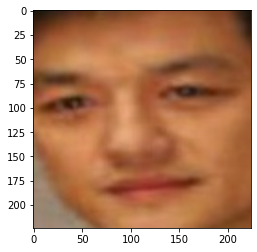

1 1


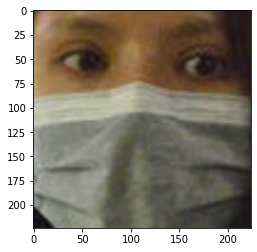

0 0


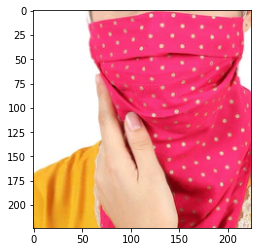

0 0


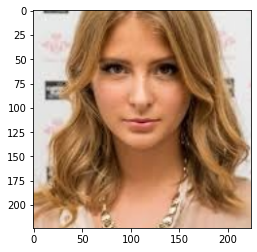

1 1


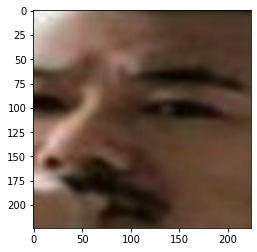

1 1


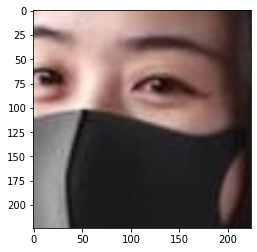

0 0


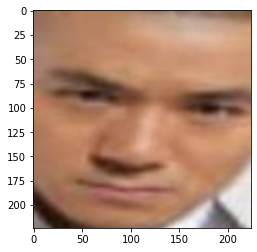

1 1


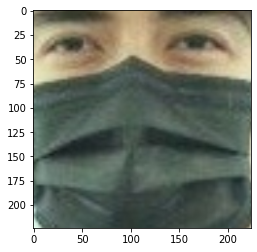

0 0


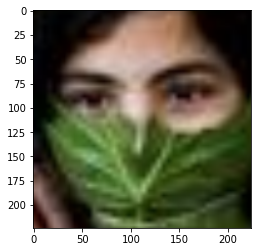

0 0


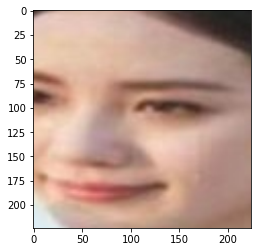

1 1


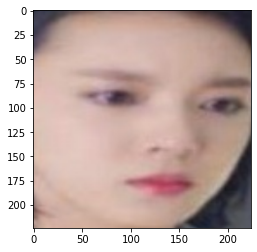

1 1


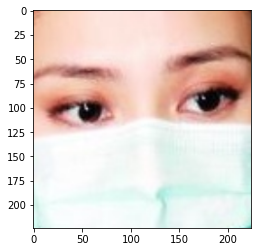

0 0


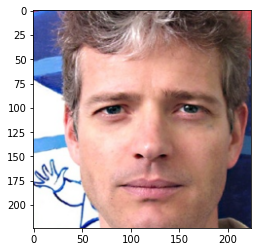

1 1


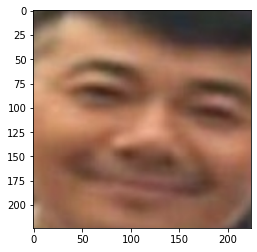

1 1


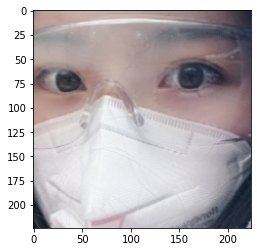

0 0


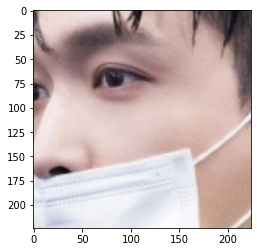

0 0


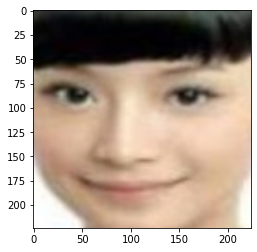

1 1


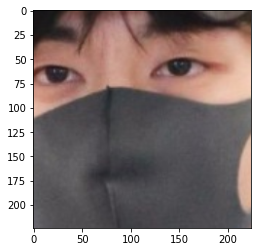

0 0


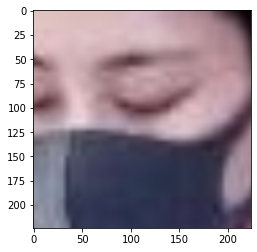

0 0


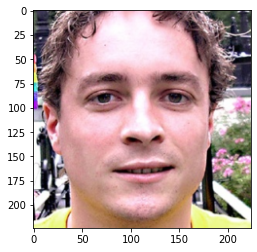

1 1


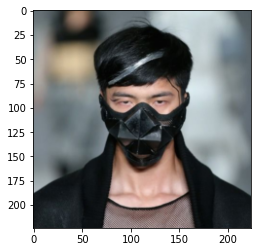

0 0


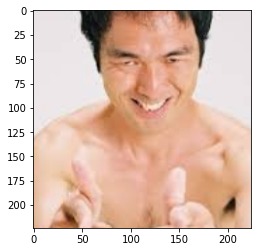

1 1


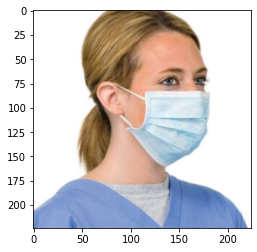

0 0
93.4065934065934


In [21]:
model.eval()
with torch.no_grad():
    num_img=0
    cor=0
    for (imgs,labels) in test_data:
        imgs = imgs.to(device)
        labels=labels.to(device)
        output=model(imgs)
        _,predicted = torch.max(output.data,1)
        cor+=(predicted == labels).sum().item()
        num_img+=predicted.shape[0]
        
        image=imgs[0]
        plt.imshow(transforms.ToPILImage()(image))
        plt.show()
        print(predicted[0].item(),labels[0].item())
        # cv2.imshow("",np.array(image)*255)
        # cv2.waitKey(0)

    print(cor/num_img*100)

In [22]:
import cv2

In [23]:
#defining prototext and caffemodel paths
caffeModel = "D:/amogh/python_projects/ML/Face_Detection/Face-detection-with-OpenCV-and-deep-learning-master/models/res10_300x300_ssd_iter_140000.caffemodel"
prototextPath = "D:/amogh/python_projects/ML/Face_Detection/Face-detection-with-OpenCV-and-deep-learning-master/models/deploy.prototxt.txt"

#Load Model
print("Loading model...................")
net = cv2.dnn.readNetFromCaffe(prototextPath,caffeModel)

Loading model...................


In [26]:
dic={0:"MASK",1:"NO MASK"}

In [29]:
# initialize the video stream to get the video frames
print("[INFO] starting video stream...")
camera=cv2.VideoCapture(0)

while True :
    
    _,image=camera.read()
    
    (h, w) = image.shape[:2]
    try:
        blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))

        net.setInput(blob)
        detections = net.forward()

        # Identify each face
        for i in range(0, detections.shape[2]):
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            confidence = detections[0, 0, i, 2]

            # If confidence > 0.5, save it as a separate file
            if (confidence > 0.5):
                frame = image[startY-50:endY+50, startX-50:endX+50]
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            # show the output frame
                test_img = np.moveaxis(frame,2,0)
            
                transform = transforms.Compose([transforms.Resize(255),
                                            transforms.CenterCrop(224),
                                            ])
                test_img=transform(torch.FloatTensor(test_img))/255
                test_imgs = torch.utils.data.DataLoader([test_img], batch_size=1, shuffle=True,num_workers=1,pin_memory=True)

                with torch.no_grad():
                    for imgs in test_imgs:
                        imgs = imgs.to(device)
                        output=model(imgs)
                        _,predicted = torch.max(output.data,1)
                    # image=imgs[0]
                    # plt.imshow(transforms.ToPILImage()(image))
                    # plt.show()
                    # print(predicted)
                
                text = "{:.2f}%".format(confidence * 100)
                y = startY - 10 if startY - 10 > 10 else startY + 10
                
                cv2.rectangle(image, (startX, startY), (endX, endY),
                            (0, 0, 255), 2)
                cv2.putText(image, text+dic[predicted.item()], (startX, y),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
    except:pass
    cv2.imshow("Frame", image)
    key = cv2.waitKey(1) & 0xFF

    # if the `q` key was pressed, break from the loop
    if key == ord("q"):
        break

# do a bit of cleanup
camera.release()
cv2.destroyAllWindows()


[INFO] starting video stream...
